In [22]:
from langgraph.graph import StateGraph,START,END
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv
from typing import TypedDict,Annotated
from pydantic import BaseModel,Field
import operator

In [23]:
load_dotenv()
model=ChatOpenAI(model='gpt-4o-mini')

In [24]:
class EvaluationSchema(BaseModel):
    feedback:str=Field(description='Detailed feedback for the essay')
    score:int=Field(description='Score out of 10',ge=0,le=10)

In [25]:
strucured_model=model.with_structured_output(EvaluationSchema)

In [26]:
essay="""
Artificial Intelligence (AI) is revolutionizing the world, and India is no exception. From healthcare and agriculture to education and governance, AI is playing an increasingly vital role in transforming the way India operates. With a rapidly growing digital economy, a massive population, and a large pool of tech talent, India is uniquely positioned to become a global leader in AI.

1. AI in Governance and Public Services

The Government of India is actively promoting the use of AI for improving governance and public services. Initiatives like Digital India and AI for All, led by NITI Aayog, aim to integrate AI in areas such as healthcare, education, agriculture, and smart cities. For example, AI-based systems are being used to detect tax fraud, improve traffic management in urban areas, and predict crime patterns.

2. AI in Healthcare

India’s healthcare system faces many challenges, including lack of access in rural areas and shortage of doctors. AI can bridge this gap. Tools like AI-based diagnostics, predictive analytics for disease outbreaks, and robotic surgeries are becoming more common. For instance, AI models can help detect diseases like tuberculosis or cancer at an early stage, saving countless lives.

3. AI in Agriculture

Agriculture is the backbone of India’s economy, and AI is helping farmers improve crop yields and manage resources efficiently. With AI-powered weather forecasts, soil analysis, and pest detection, farmers can make informed decisions. Platforms like Kisan Suvidha use AI to offer real-time information about market prices, weather, and best practices.

4. AI in Education

AI is reshaping the Indian education system by offering personalized learning experiences. Edtech companies are using AI to analyze students' performance and suggest customized learning paths. AI-driven chatbots are also being used for student support and counseling. This is especially important in rural areas where qualified teachers may be lacking.

5. AI in Industry and Employment

Industries such as finance, manufacturing, and logistics are rapidly adopting AI to improve efficiency and reduce costs. However, there is also concern about job displacement due to automation. To address this, India is investing in skilling and reskilling programs to prepare its workforce for the AI-driven future. The National Skill Development Corporation (NSDC) and private companies are offering AI and machine learning courses to students and professionals.

6. Challenges and the Way Forward

Despite its potential, the adoption of AI in India faces several challenges, including lack of infrastructure, data privacy concerns, and low awareness among the general public. There is also a digital divide between urban and rural areas. To overcome these, India needs stronger policies, investment in AI research, and ethical guidelines to ensure AI is used responsibly.

Conclusion

Artificial Intelligence has the potential to significantly impact India's growth and development. With the right policies, investment, and education, AI can help solve some of India's biggest problems—whether it's in health, education, agriculture, or governance. India must continue to embrace AI not just as a tool of technology, but as a driver of inclusive and sustainable growth.
"""

In [27]:
prompt=f'Evaluate the language quality of the following essay and provide a feedback and assign a score out of 10 \n {essay}'
strucured_model.invoke(prompt)

EvaluationSchema(feedback="The essay presents a well-structured overview of the impact of Artificial Intelligence (AI) in various sectors in India, including governance, healthcare, agriculture, education, and industry. The language used is clear and concise, making the complex topic accessible to a wide audience. However, there are some areas for improvement:\\n\\n1. **Clarity and Style**: While the essay is overall clear, some sentences could be more concise to enhance readability. For example, the phrase 'AI is playing an increasingly vital role in transforming the way India operates' could be simplified to 'AI is transforming India's operations.'\\n\\n2. **Engagement and Depth**: Each section provides good examples, but a deeper analysis of the implications of AI adoption would enhance the essay. Discussing both the positive and negative consequences, especially more specific case studies, could provide a more nuanced perspective. \\n\\n3. **Transitions and Flow**: The essay flows 

In [28]:
strucured_model.invoke(prompt).feedback

"The essay is well-structured and covers significant aspects of how artificial intelligence (AI) is influencing various sectors in India, including governance, healthcare, agriculture, education, and industry. Each section is clear and provides relevant examples, which strengthens the argument. The language used is mostly clear and formal, appropriate for an academic or analytical piece. However, there are areas for improvement:\n\n1. **Clarity and Cohesion**: While the sections are well-defined, a strong thesis statement in the introduction could help unify the essay. The transitions between paragraphs can be smoother to enhance coherence.\n2. **Depth of Analysis**: Some sections, especially on governance and education, could benefit from deeper analysis or additional examples to illustrate the impacts of AI.\n3. **Grammar and Style**: There are minor grammatical issues and repetitive phrases such as 'AI is helping' or 'AI is being used' that could be varied to enhance the overall sty

In [29]:
strucured_model.invoke(prompt).score


8

In [31]:
class UPSCState(TypedDict):
    essay:str
    language_feedback:str
    analysis_feedback:str
    clarity_feedback:str
    overall_feedback:str
    individual_scores:Annotated[list[int],operator.add]
    avg_score:float

In [32]:
def evaluate_language(state:UPSCState)->UPSCState:
    prompt=f'Evaluate the language quality of the following essay and provide a feedback and assign a score out of 10 \n {state["essay"]}'
    output=strucured_model.invoke(prompt)
    return {'language_feedback':output.feedback,'individual_scores':[output.score]}


In [33]:
def evaluate_analysis(state:UPSCState)->UPSCState:
    prompt=f'Evaluate the depth of analysis of the following essay and provide a feedback and assign a score out of 10 \n {state["essay"]}'
    output=strucured_model.invoke(prompt)
    return {'analysis_feedback':output.feedback,'individual_scores':[output.score]}


In [34]:
def evaluate_thought(state:UPSCState)->UPSCState:
    prompt=f'Evaluate the clarity of thought of the following essay and provide a feedback and assign a score out of 10 \n {state["essay"]}'
    output=strucured_model.invoke(prompt)
    return {'clarity_feedback':output.feedback,'individual_scores':[output.score]}


In [36]:
def final_evaluation(state:UPSCState)->UPSCState:
    #summary feedback
    prompt=f"Based on the following feedbacks create a summarized feedback \n language feedback -{state['language_feedback']} \n depth of analysis feedback - {state['analysis_feedback']} \n clarity of thought feedback - {state['clarity_feedback']}"
    overall_feedback=model.invoke(prompt).content
    #avg calculate
    avg_score=sum(state['individual_scores'])/len(state['individual_scores'])
    return {'overall_feedback':overall_feedback,'avg_score':avg_score}

In [37]:
graph=StateGraph(UPSCState)

graph.add_node('evaluate_language',evaluate_language)
graph.add_node('evaluate_analysis',evaluate_analysis)
graph.add_node('evaluate_thought',evaluate_thought)
graph.add_node('final_evaluation',final_evaluation)

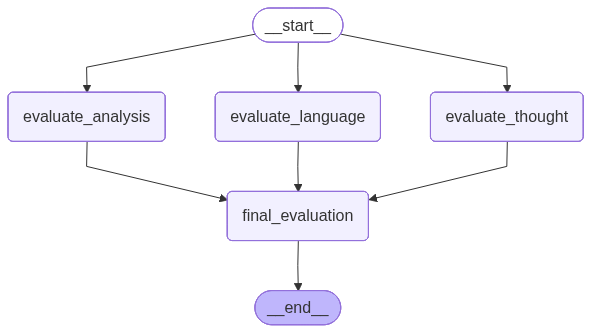

In [38]:
graph.add_edge(START,'evaluate_language')
graph.add_edge(START,'evaluate_analysis')
graph.add_edge(START,'evaluate_thought')

graph.add_edge('evaluate_language','final_evaluation')
graph.add_edge('evaluate_analysis','final_evaluation')
graph.add_edge('evaluate_thought','final_evaluation')
graph.add_edge('final_evaluation',END)

workflow=graph.compile()
workflow

In [39]:
inital_state={'essay':essay}
workflow.invoke(inital_state)

{'essay': "\nArtificial Intelligence (AI) is revolutionizing the world, and India is no exception. From healthcare and agriculture to education and governance, AI is playing an increasingly vital role in transforming the way India operates. With a rapidly growing digital economy, a massive population, and a large pool of tech talent, India is uniquely positioned to become a global leader in AI.\n\n1. AI in Governance and Public Services\n\nThe Government of India is actively promoting the use of AI for improving governance and public services. Initiatives like Digital India and AI for All, led by NITI Aayog, aim to integrate AI in areas such as healthcare, education, agriculture, and smart cities. For example, AI-based systems are being used to detect tax fraud, improve traffic management in urban areas, and predict crime patterns.\n\n2. AI in Healthcare\n\nIndia’s healthcare system faces many challenges, including lack of access in rural areas and shortage of doctors. AI can bridge th